### 🗂️ DATA INSPECTION AND ANALYSIS

Before evaluating the models, a detailed inspection of the dataset was conducted to understand the **typology of data** and tailor the evaluation metrics accordingly.

---

### Answer Types Distribution

The dataset consists of structured QA entries, each containing one or more **expected answers** (`exe_ans`). These answers fall into two primary categories:

- **Numerical answers** (e.g., revenue figures, ratios, growth rates)  
- **Boolean string answers**, strictly `"yes"` or `"no"`  

Through the analysis of the dataset fields (`qa`, `qa_0`, `qa_1`), it was observed that:

- The **vast majority** of entries contain **numerical answers**
- Only a **small fraction** of entries involve **string responses**
- Among string values, **100%** of them are either `"yes"` or `"no"` (case-insensitive, whitespace-normalized)

---


In [112]:
# data path
data_path = "/Users/francescostocchi/ConvFinQA_LLM_Project/data/train.json"
# directory path
directory = "/Users/francescostocchi/ConvFinQA_LLM_Project/results"

# extract data
import json
import pandas as pd
with open(data_path, "r") as f:
    data = json.load(f)

# convert to dataframe
df = pd.DataFrame(data)

# print the first few rows
print(df.head())    

                                            pre_text  \
0  [26 | 2009 annual report in fiscal 2008 , reve...   
1  [substantially all of the goodwill and other i...   
2  [in a new business model such as the retail se...   
3  [( 1 ) includes shares repurchased through our...   
4  [( 1 ) includes shares repurchased through our...   

                                           post_text               filename  \
0  [year ended june 30 , cash provided by operati...  JKHY/2009/page_28.pdf   
1  [the above unaudited pro forma financial infor...  RSG/2008/page_114.pdf   
2                                                [.]  AAPL/2002/page_23.pdf   
3                                                [.]   UPS/2009/page_33.pdf   
4                                                [.]   UPS/2009/page_33.pdf   

                                           table_ori  \
0  [[, Year ended June 30, 2009], [2008, 2007], [...   
1  [[, Year Ended December 31, 2008 (Unaudited), ...   
2  [[, 2002, 2001, 2

In [113]:
# remove unnecessary columns
df = df.drop(columns=["annotation", "filename"])

# print a list of df columns
print(df.columns)


Index(['pre_text', 'post_text', 'table_ori', 'table', 'qa', 'id', 'qa_0',
       'qa_1'],
      dtype='object')


In [114]:
# Count the number of valid (non-null) entries
qa = df["qa"].notnull().sum()
qa_0 = df["qa_0"].notnull().sum()
qa_1 = df["qa_1"].notnull().sum()

# Sum them to get the total number of questions
total_number_of_questions = qa + qa_0 + qa_1

# Print the result
print(f"The total number of questions in the dataset is: {total_number_of_questions}")



The total number of questions in the dataset is: 3965


In [115]:
# check if all the questions have an exact answer
def check_exe_ans(qa):
    return isinstance(qa, dict) and "exe_ans" in qa

# Drop NaNs before applying the check
if df["qa"].dropna().apply(check_exe_ans).all() and df["qa_0"].dropna().apply(check_exe_ans).all() and df["qa_1"].dropna().apply(check_exe_ans).all():
    print("Exact answer is present in all the question fields (excluding NaNs)")
else:
    print("Some questions are missing the exact answer field (excluding NaNs)")

Exact answer is present in all the question fields (excluding NaNs)


In [116]:
# analyze the kind of answers 
def get_exe_ans_type(qa):
    if isinstance(qa, dict) and "exe_ans" in qa:
        val = qa["exe_ans"]
        if isinstance(val, (int, float)):
            return "number"
        elif isinstance(val, str):
            return "string"
        else:
            return type(val).__name__  # catch other types like list, None, etc.
    return "missing"

# apply the function to the qa column
df["exe_ans_type_qa"] = df["qa"].dropna().apply(get_exe_ans_type)

print(df["exe_ans_type_qa"].value_counts())

 # apply the function to the qa_0 column
df["exe_ans_type_qa_0"] = df["qa_0"].dropna().apply(get_exe_ans_type)
print(df["exe_ans_type_qa_0"].value_counts())

# apply the function to the qa_1 column
df["exe_ans_type_qa_1"] = df["qa_1"].dropna().apply(get_exe_ans_type)
print(df["exe_ans_type_qa_1"].value_counts())


exe_ans_type_qa
number    2101
string       8
Name: count, dtype: int64
exe_ans_type_qa_0
number    916
string     12
Name: count, dtype: int64
exe_ans_type_qa_1
number    904
string     24
Name: count, dtype: int64


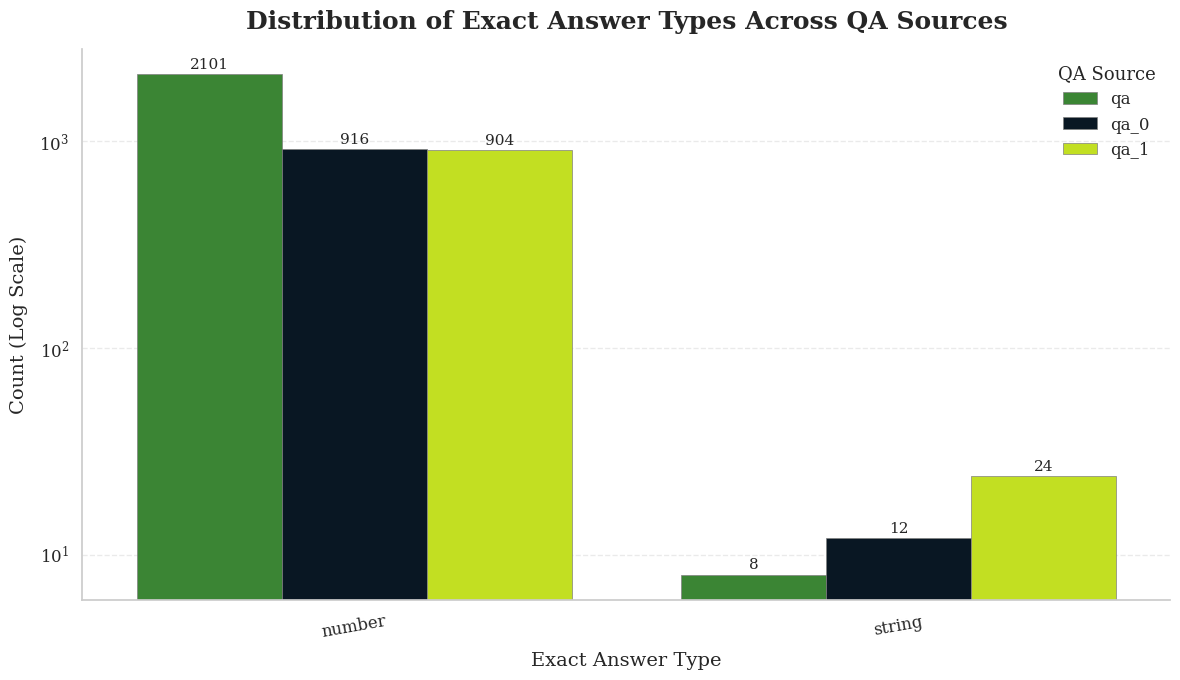

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn styling and serif font
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams['font.family'] = 'serif'

# Define the custom palette
tomoro_palette = {
    'qa': '#309227',   # Green
    'qa_0': '#051827', # Dark Blue
    'qa_1': '#d8ff02'  # Yellow
}

# Apply type detection to all three columns
df["exe_ans_type_qa"] = df["qa"].apply(get_exe_ans_type)
df["exe_ans_type_qa_0"] = df["qa_0"].apply(get_exe_ans_type)
df["exe_ans_type_qa_1"] = df["qa_1"].apply(get_exe_ans_type)

# Combine results into a single DataFrame for plotting
type_data = pd.concat([
    df[["exe_ans_type_qa"]].rename(columns={"exe_ans_type_qa": "type"}).assign(source="qa"),
    df[["exe_ans_type_qa_0"]].rename(columns={"exe_ans_type_qa_0": "type"}).assign(source="qa_0"),
    df[["exe_ans_type_qa_1"]].rename(columns={"exe_ans_type_qa_1": "type"}).assign(source="qa_1"),
])

# Filter out "missing"
type_data = type_data[type_data["type"] != "missing"]

# Plot
plt.figure(figsize=(12, 7))
ax = sns.countplot(
    data=type_data,
    x="type",
    hue="source",
    palette=tomoro_palette,
    edgecolor="gray",
    linewidth=0.5
)

# Titles and labels
plt.title("Distribution of Exact Answer Types Across QA Sources", fontsize=18, weight='bold', pad=15)
plt.xlabel("Exact Answer Type", fontsize=14, labelpad=8)
plt.ylabel("Count (Log Scale)", fontsize=14, labelpad=8)

# Axes styling
plt.xticks(fontsize=12, rotation=10)
plt.yticks(fontsize=12)
plt.yscale("log")
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()

# Add clean value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=11, padding=2)

# Legend styling
legend = plt.legend(
    title="QA Source", title_fontsize=13, fontsize=12,
    loc='upper right', frameon=False
)

# Final layout
plt.tight_layout()
plt.show()


In [ ]:
# Check if ALL string values in exe_ans are either "yes" or "no"
def all_string_answers_yes_no(column):
    return not column.apply(
        lambda qa: isinstance(qa, dict) and isinstance(qa.get("exe_ans"), str) and qa["exe_ans"].strip().lower() not in ["yes", "no"]
    ).any()

if all_string_answers_yes_no(df["qa"]) and all_string_answers_yes_no(df["qa_0"]) and all_string_answers_yes_no(df["qa_1"]):
    print("Yes — all string answers are either 'yes' or 'no'")
else:
    print("Some string answers are NOT 'yes' or 'no'")



### 🧠 AGENTIC MODEL EVALUATION

This experiment evaluates the performance of three leading LLMs:
- **GPT-4o** from OpenAI  
- **Claude 3.7 Sonnet** from Anthropic  
- **Gemini 2.0 Flash** from Google  

### Prompting Strategies (Prompt Styles)

The evaluation includes three distinct **prompt styles**, each designed to test different agent capabilities:

| Prompt Style   | Name          | Description |
|----------------|---------------|-------------|
| **JSON-Chat**  | `json-chat`   | A custom prompt template using a **system** and **user prompt** defined in a structured way within the prompt templates file. This prompt is optimized for clarity and consistency in numerical QA. |
| **ReAct**      | `react`       | A **ReAct-style** prompt where the model is guided to follow a reasoning-then-acting structure. It mimics classical step-by-step CoT (Chain-of-Thought) reasoning followed by action. |
| **Tool Agent** | `tools-agent` | A tool-oriented prompt that explicitly encourages the model to use **tool calls**. It's crafted to test how well the model can interact with external tools (e.g., calculators, parsers) during reasoning. |

Each prompt style is evaluated independently to observe how **prompt engineering** affects model performance on both numeric and boolean tasks.

---

These prompt strategies help assess:
- The model’s ability to **reason step-by-step**
- Its capacity to **trigger and use external tools**
- Its consistency in producing **well-formatted, verifiable answers**
The evaluation focuses on **numerical accuracy** and **string classification correctness** over a randomly selected sample of **20 entries**, which represents approximately **1% of the total dataset**. Due to resource constraints (API call limits), this sample offers only a **low-statistical-validity** glimpse into the models' capabilities. However, the methodology scales to the full dataset for comprehensive evaluation when needed.

---

### Evaluation Methodology

The evaluation is conducted using a custom metric function: `measure_accuracy`, supported by two helper functions: `compute_single_sample_accuracy` and `evaluate_answer`. Here's an explanation of each.

---

#### `measure_accuracy(...)`

This is the **main evaluation function**, which:
- Randomly samples a subset of questions from a given dataset.
- Prompts the agentic model to answer the questions.
- Compares the model’s output (`actual_answers`) with the ground truth (`expected_answers`).
- Returns key metrics:  
  - `mean_accuracy`: overall % of correct answers  
  - `mae`: mean absolute error for numeric predictions  
  - `mse`: mean squared error for numeric predictions  
  - `accuracy_measurements`: list of 0/1 indicating per-answer correctness
  - `llm_average_score`: overall % of correct answers 

A **tolerance margin** is applied to numeric comparisons to account for minor variations. Answers outside the tolerance are considered incorrect. For string answers (e.g., "yes"/"no"), a strict match is used after lowercasing and removing spaces.

---

#### `compute_single_sample_accuracy(...)`

This sub-function performs **answer-level comparison**:
- For **numeric answers**:  
  - Compares using `abs(expected - actual)`  
  - Applies the `tolerance` threshold to mark correctness (score 1 or 0)  
  - Calculates **MAE** and **MSE**
- For **string answers**:  
  - Performs strict comparison after normalization (lowercased, whitespace removed)  
  - Only "yes" and "no" are valid answers; all others are treated as incorrect
- Supports **asymmetric lengths** between predicted and expected answers by scoring missing answers as incorrect.

---

#### `evaluate_answer(...)`

This optional function introduces an **LLM-as-a-judge** approach:
- Used when the model's answer might be in an unexpected format (e.g., verbose explanations, embedded numbers, misformatted strings).
- It sends the original question, expected answer, and the model's response to another LLM acting as a "judge".
- The judge returns a score (e.g., 1 or 0) and an **explanation**.

This provides an **additional quality-control layer** that can catch cases where a numerically correct answer is returned in the wrong format and would otherwise be unfairly marked as incorrect.

---

### Metrics Summary

Since most of the answers in the dataset are **numerical**, the metrics naturally emphasize:
- **Numerical Accuracy**
- **MAE (Mean Absolute Error)**
- **MSE (Mean Squared Error)**

The few **string-based answers** (all either "yes" or "no") are treated as **binary classification tasks** using exact matching.

---

### Why This Approach?

- **Lightweight**: The method can evaluate a small sample with minimal cost.
- **Scalable**: Easily extends to evaluate the full dataset.
- **Robust**: Supports both numeric and string answer types.
- **Adaptable**: The LLM-judge adds human-like reasoning for edge cases.

---

### Limitations

- The 20-sample evaluation is **not statistically significant** and meant only for indicative benchmarking.
- String answer evaluation is **strict** — any extra formatting or words can cause a mismatch unless the LLM-judge is used.

---



In [ ]:
import sys
import os
# Save the metrics to a JSON file
import json 
from datetime import datetime


# Go up one directory to reach the project root
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import importlib
import src.utils.data_extractor
importlib.reload(src.utils.data_extractor)
import importlib
import src.metrics.accuracy  
importlib.reload(src.metrics.accuracy)
import src.agent.agent_builder
#importlib.reload(src.agent.agent_builder)
import src.agent.agent_tools
importlib.reload(src.agent.agent_tools)
import src.agent.prompt_templates
importlib.reload(src.agent.prompt_templates)

# Re-import the function
from src.metrics.accuracy import measure_accuracy



In [ ]:
# setting the number of samples
number_samples = 10

#### TESTING OPENAI MODEL

In [ ]:
model = "gpt-4o"
provider = "openai"
tolerance = 0.005


In [ ]:
## TESTING REACT PROMPT STYLE
prompt_style = "react"  

# save the the metrics for gpt-4o_react 
metrics_gpt4o_react = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for gpt-4o_react:")
for key, value in metrics_gpt4o_react.items():
    print(f"{key}: {value}")
    
# Save the metrics to a JSON file
import json 
from datetime import datetime

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gpt4o_react, f, indent=4)

print(f"Metrics saved successfully to {file_path}")


In [ ]:
## TESTING JSON-CHAT PROMPT STYLE
prompt_style = "json-chat"  

# save the the metrics for gpt-4o_react 
metrics_gpt4o_custom = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)


In [ ]:
## print the metrics
print("Metrics for gpt-4o_customt:")
for key, value in metrics_gpt4o_custom.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gpt4o_custom, f, indent=4)

print(f"Metrics saved successfully to {file_path}")


In [ ]:
## TESTING TOOLS-AGENT PROMPT STYLE
prompt_style = "few-shot-CoT"  

# save the the metrics for TOOLS-AGENT 
metrics_gpt4o_cot = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for gpt-4o_tool:")
for key, value in metrics_gpt4o_cot.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gpt4o_cot, f, indent=4)

print(f"Metrics saved successfully to {file_path}")


#### TESTING ANTHROPIC MODEL

In [ ]:
# model = "claude-3-7-sonnet-20250219"
# model = "claude-3-5-haiku-20241022"
model = "claude-3-5-sonnet-20241022"
provider = "anthropic"
tolerance = 0.005


In [ ]:
## TESTING REACT PROMPT STYLE
prompt_style = "react"  

# save the the metrics for gpt-4o_react 
metrics_sonnet3_7_react = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for sonnet_3_5_react:")
for key, value in metrics_sonnet3_7_react.items():
    print(f"{key}: {value}")
    
# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_sonnet3_7_react, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

In [ ]:
## TESTING JSON-CHAT PROMPT STYLE
prompt_style = "json-chat"  

# save the the metrics for gpt-4o_react 
metrics_sonnet3_7_custom = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for sonnet_3_5_custom:")
for key, value in metrics_sonnet3_7_custom.items():
    print(f"{key}: {value}")
    
# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_sonnet3_7_custom, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

In [ ]:
## TESTING  PROMPT STYLE
prompt_style = "few-shot-CoT"  

# save the the metrics for gpt-4o_react 
metrics_sonnet3_7_cot = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for sonnet3_5_few_shot_react:")
for key, value in metrics_sonnet3_7_cot.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_sonnet3_7_cot, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

#### TESTING GOOGLE MODEL

In [ ]:
model = "gemini-2.0-flash"
provider = "google"
tolerance = 0.005


In [ ]:
## TESTING REACT PROMPT STYLE
prompt_style = "react"  

metrics_gemini_react = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for gemini_react:")
for key, value in metrics_gemini_react.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gemini_react, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

In [ ]:
## TESTING REACT PROMPT STYLE
prompt_style = "json-chat"  

metrics_gemini_json_chat = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for gemini_custom:")
for key, value in metrics_gemini_json_chat.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gemini_json_chat, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

In [ ]:
## TESTING REACT PROMPT STYLE
prompt_style = "few-shot-CoT"  

metrics_gemini_cot = measure_accuracy(
    data_path=data_path,
    model=model,
    provider=provider,
    prompt_style=prompt_style,
    tolerance=tolerance,
    number_samples=number_samples,
    verbose=True
)

In [ ]:
## print the metrics
print("Metrics for gemini_custom:")
for key, value in metrics_gemini_cot.items():
    print(f"{key}: {value}")

# Create a timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define directory and dynamic filename
filename = f"metrics_{model}_{prompt_style}_{timestamp}.json"
file_path = os.path.join(directory, filename)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Save the metrics to the JSON file
with open(file_path, "w") as f:
    json.dump(metrics_gemini_cot, f, indent=4)

print(f"Metrics saved successfully to {file_path}")

### PLOTS FOR COMPARISON 

In [ ]:
import os
import json

# Path to the results folder
results_folder = "/Users/francescostocchi/ConvFinQA_LLM_Project/results"

# Dictionary to store results
model_results = {}

# Helper function to normalize names
def normalize_model_prompt(filename):
    name = filename.lower()
    
    # Determine model name
    if "gpt-4o" in name:
        model = "gpt-4o"
    elif "claude-3-5-sonnet" in name:
        model = "claude-3.5-sonnet"
    elif "claude-3-7-sonnet" in name:
        model = "claude-3.7-sonnet"
    elif "gemini" in name:
        model = "gemini-2.0-flash"
    else:
        model = "unknown"

    # Determine prompt type
    if "few-shot-cot" in name:
        prompt = "few-shot-CoT"
    elif "json-chat" in name:
        prompt = "json-chat"
    elif "react" in name:
        prompt = "react"
    else:
        prompt = "unknown"

    return model, prompt

# Iterate through files in the results folder
for filename in os.listdir(results_folder):
    if filename.endswith(".json"):
        filepath = os.path.join(results_folder, filename)
        
        with open(filepath, "r") as f:
            data = json.load(f)
        
        model, prompt = normalize_model_prompt(filename)
        if model not in model_results:
            model_results[model] = {}

        # Save relevant metrics
        model_results[model][prompt] = {
            "mean_accuracy": data.get("mean_accuracy"),
            "mae": data.get("mae"),
            "mse": data.get("mse"),
            "llm_average_score": data.get("llm_average_score"),
        }

# print the results
from pprint import pprint
pprint(model_results)


In [ ]:
## COMPARISON OF MODELS FOR EACH PROMPT

# custom palette for plotting
tomoro_palette = {
    'gpt-4o': '#309227',   # Green
    'claude-3.5-sonnet': '#051827', # Dark Blue
    'gemini-2.0-flash': '#d8ff02'  # Yellow
}

# Prepare the DataFrame
rows = []
for model, prompts in model_results.items():
    for prompt, metrics in prompts.items():
        rows.append({
            "model": model,
            "prompt": prompt,
            "mean_accuracy": metrics.get("mean_accuracy", 0)
        })

df = pd.DataFrame(rows)

# Create one plot per prompt
for prompt_name in df["prompt"].unique():
    prompt_df = df[df["prompt"] == prompt_name]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=prompt_df, x="model", y="mean_accuracy", palette=tomoro_palette)

    # Title and labels
    plt.title(f"Model Comparison for Prompt: {prompt_name}", fontsize=18, weight='bold')
    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Mean Accuracy", fontsize=14)

    # Styling
    plt.ylim(0, 1)
    plt.xticks(rotation=15, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [ ]:
# Set seaborn styling
sns.set(style="whitegrid")

# Your current palette:
tomoro_palette = {
    'json-chat': '#309227',     # Green
    'few-shot-CoT': '#051827',  # Dark Blue
    'react': '#d8ff02'          # Yellow
}

# Loop through each model
for model, prompts in model_results.items():
    # Build DataFrame
    data = {
        "prompt": list(prompts.keys()),
        "mean_accuracy": [metrics["mean_accuracy"] for metrics in prompts.values()]
    }
    df_model = pd.DataFrame(data)

    # Match color order from tomoro_palette
    colors = [tomoro_palette[p] for p in df_model["prompt"]]

    # Create plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_model,
        x="prompt",
        y="mean_accuracy",
        palette=colors,
        edgecolor="black"
    )

    # Titles and labels
    plt.title(f"Prompt Comparison for {model}", fontsize=20, weight='bold', pad=20)
    plt.xlabel("Prompt Type", fontsize=16, labelpad=10)
    plt.ylabel("Mean Accuracy", fontsize=16, labelpad=10)

    # Ticks
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim(0, 1)

    # Grid
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, padding=3)

    # Final layout
    plt.tight_layout()
    plt.show()


In [ ]:
## COMPARE ACROSS ALL PROMPTS AND MODELS
# Your current palette:
tomoro_palette = {
    'gpt-4o': '#309227',     # Green
    'claude-3.5-sonnet': '#051827',  # Dark Blue
    'gemini-2.0-flash': '#d8ff02'          # Yellow
}

# Seaborn styling
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

# Font style (optional but more academic)
plt.rcParams['font.family'] = 'serif'

# Normalize prompt labels (in case needed for other logic)
def normalize_prompt(p):
    return p.lower().replace(" ", "-")

df["prompt_normalized"] = df["prompt"].apply(normalize_prompt)

# Sort for consistent groupings
df = df.sort_values(by=["prompt", "model"])

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x="prompt",
    y="mean_accuracy",
    hue="model",
    palette=tomoro_palette,
    edgecolor="gray",  # subtle bar edge
    linewidth=0.5
)

# Titles and labels
plt.title("Mean Accuracy Comparison Across Models and Prompts", fontsize=18, weight='bold', pad=15)
plt.xlabel("Prompt Type", fontsize=14, labelpad=8)
plt.ylabel("Mean Accuracy", fontsize=14, labelpad=8)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()  # Removes top and right border

# Add clean value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=11, padding=2)

# Legend styling
legend = plt.legend(
    title="Model", title_fontsize=13, fontsize=12,
    loc='upper left', frameon=False
)

# Final layout
plt.tight_layout()
plt.show()

In [ ]:
## COMPARE PROMPTS ACROSS ALL MODELS

# Set seaborn styling
sns.set(style="whitegrid")

# Your current palette:
tomoro_palette = {
    'json-chat': '#309227',     # Green
    'few-shot-CoT': '#051827',  # Dark Blue
    'react': '#d8ff02'          # Yellow
}

# Loop through each model
for model, prompts in model_results.items():
    # Build DataFrame
    data = {
        "prompt": list(prompts.keys()),
        "llm_average_score": [metrics["llm_average_score"] for metrics in prompts.values()]
    }
    df_model = pd.DataFrame(data)

    # Match color order from tomoro_palette
    colors = [tomoro_palette[p] for p in df_model["prompt"]]

    # Create plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_model,
        x="prompt",
        y="llm_average_score",
        palette=colors,
        edgecolor="black"
    )

    # Titles and labels
    plt.title(f"Prompt Comparison for {model}", fontsize=20, weight='bold', pad=20)
    plt.xlabel("Prompt Type", fontsize=16, labelpad=10)
    plt.ylabel("LLM Average Score", fontsize=16, labelpad=10)

    # Ticks
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim(0, 1)

    # Grid
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12, padding=3)

    # Final layout
    plt.tight_layout()
    plt.show()

In [ ]:
## COMPARE ACROSS ALL PROMPTS AND MODELS USING LLM AVERAGE SCORE
## COMPARE ACROSS ALL PROMPTS AND MODELS
# Your current palette:
tomoro_palette = {
    'gpt-4o': '#309227',     # Green
    'claude-3.5-sonnet': '#051827',  # Dark Blue
    'gemini-2.0-flash': '#d8ff02'          # Yellow
}
# Rebuild df from model_results with llm_average_score
rows = []
for model, prompts in model_results.items():
    for prompt, metrics in prompts.items():
        rows.append({
            "model": model,
            "prompt": prompt,
            "llm_average_score": metrics.get("llm_average_score", None)
        })

df = pd.DataFrame(rows)

# Seaborn styling
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

# Font style (optional but more academic)
plt.rcParams['font.family'] = 'serif'

# Normalize prompt labels (in case needed for other logic)
def normalize_prompt(p):
    return p.lower().replace(" ", "-")

df["prompt_normalized"] = df["prompt"].apply(normalize_prompt)

# Sort for consistent groupings
df = df.sort_values(by=["prompt", "model"])

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x="prompt",
    y="llm_average_score",
    hue="model",
    palette=tomoro_palette,
    edgecolor="gray",  # subtle bar edge
    linewidth=0.5
)

# Titles and labels
plt.title("LLM Average Score Comparison Across Models and Prompts", fontsize=18, weight='bold', pad=15)
plt.xlabel("Prompt Type", fontsize=14, labelpad=8)
plt.ylabel("LLM Average Score", fontsize=14, labelpad=8)

# Axes styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()  # Removes top and right border

# Add clean value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=11, padding=2)

# Legend styling
legend = plt.legend(
    title="Model", title_fontsize=13, fontsize=12,
    loc='upper left', frameon=False
)

# Final layout
plt.tight_layout()
plt.show()